## Hello

Thank you for taking the time to review my work. I’m approaching this assignment as a social data scientist with a dual focus: delivering technically sound solutions while ensuring they’re interpretable and actionable for both technical and non-technical stakeholders. I position myself as a bridge between upstream data experts (I try to write modular code and make their life a bit easier) and downstream decision-makers (I refrain from using scary acronyms).

In [33]:
## !pip install -q kagglehub pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


I will start by downloading and loading the dataset, followed by a simple EDA to understand what I’m dealing with.

In [34]:
# === ETL ===

def download_dataset():
    path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")
    print("📁 Dataset downloaded to:", path)
    return path

def load_dataset(path):
    df_fake = pd.read_csv(f"{path}/Fake.csv", parse_dates=["date"])
    df_real = pd.read_csv(f"{path}/True.csv", parse_dates=["date"])
    df_fake["label"] = 0
    df_real["label"] = 1
    df = pd.concat([df_fake, df_real], ignore_index=True)
    return df

def clean_dataset(df):
    df = df.dropna(subset=["text", "title", "date", "subject"])
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    return df

def standardize_domains(df):
    df["subject"] = df["subject"].str.strip().str.title()
    df["domain"] = df["subject"].map({
        "News": "News",
        "Politics": "Politics"
    }).fillna("Other")
    return df

# Run ETL
dataset_path = download_dataset()
df = load_dataset(dataset_path)
df = clean_dataset(df)
df = standardize_domains(df)

df[["title", "text", "domain", "date", "label"]].head()


📁 Dataset downloaded to: /Users/moneerayassien/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1


,title,text,domain,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",Other,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,Other,2017-04-05 00:00:00,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,Other,2017-09-27 00:00:00,1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",Other,2016-06-24 00:00:00,1


Now I conduct an EDA with a focus on linguistic structure, rhetorical patterns, and temporal trends — aiming to inform feature engineering and support model interpretability from a computational social science perspective.


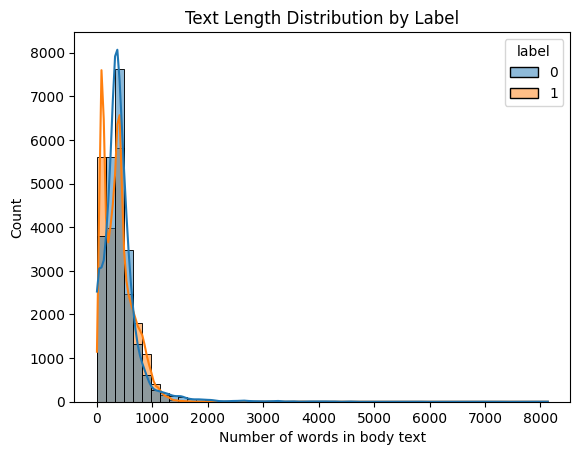

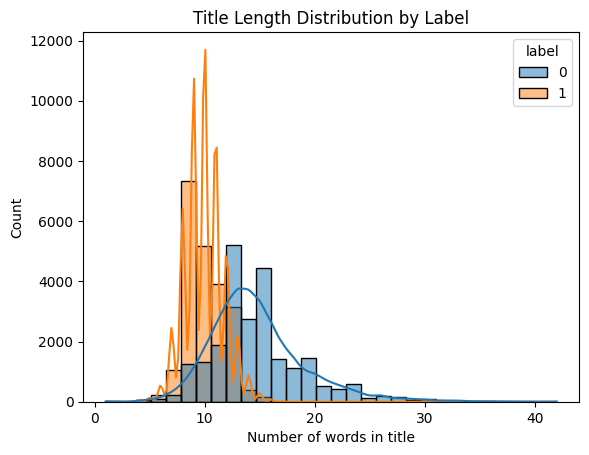

In [35]:
#1.Title vs. Text Length Distribution
def add_length_features(df):
    df["text_len"] = df["text"].apply(lambda x: len(str(x).split()))
    df["title_len"] = df["title"].apply(lambda x: len(str(x).split()))
    return df

def plot_length_distributions(df):
    sns.histplot(data=df, x="text_len", hue="label", bins=50, kde=True)
    plt.title("Text Length Distribution by Label")
    plt.xlabel("Number of words in body text")
    plt.show()

    sns.histplot(data=df, x="title_len", hue="label", bins=30, kde=True)
    plt.title("Title Length Distribution by Label")
    plt.xlabel("Number of words in title")
    plt.show()

df = add_length_features(df)
plot_length_distributions(df)


Fake articles tend to have shorter body text but longer, more consistently structured titles, possibly to project coherence and credibility. Horne and Adali (2021) argue that fake news resembles satire more than real news, using stylistic cues to appear legitimate without adhering to journalistic depth.

/var/folders/vh/5bn1_h257r32nfrrpmqcstn00000gn/T/ipykernel_99160/370032818.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(key="date", freq="M"),


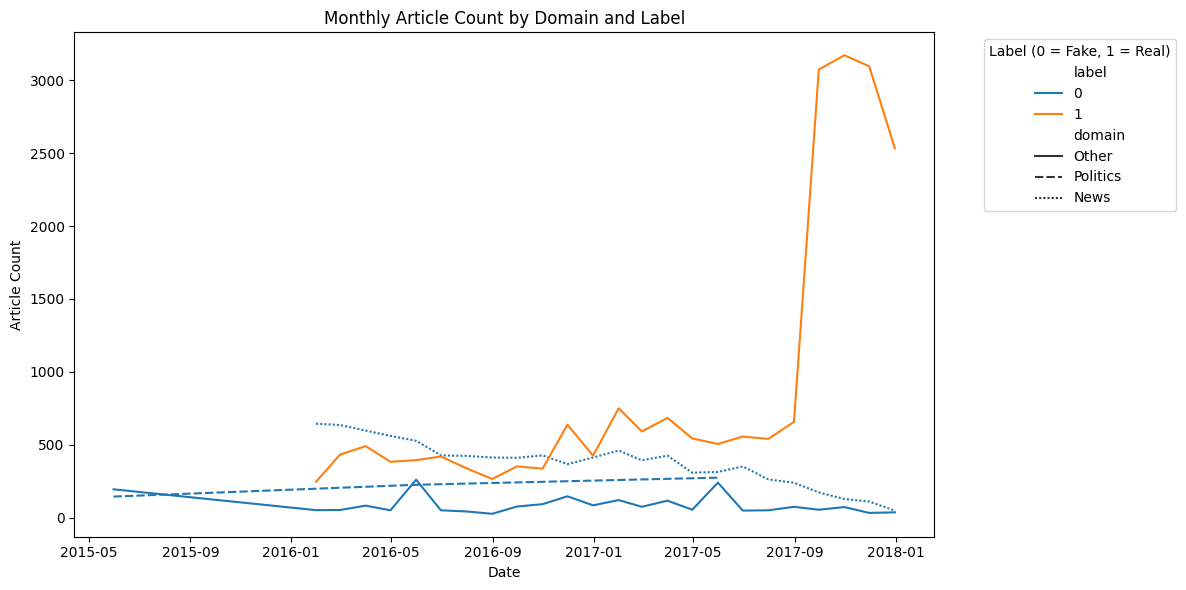

In [36]:
#2. Time Series Analysis by Subject
def group_time_series(df):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date", "domain"])
    ts_df = df.groupby([
        pd.Grouper(key="date", freq="M"),
        "domain",
        "label"
    ]).size().reset_index(name="count")
    return ts_df

def plot_time_series(ts_df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=ts_df, x="date", y="count", hue="label", style="domain")
    plt.title("Monthly Article Count by Domain and Label")
    plt.xlabel("Date")
    plt.ylabel("Article Count")
    plt.legend(title="Label (0 = Fake, 1 = Real)", bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

ts_df = group_time_series(df)
plot_time_series(ts_df)


Given the time constraints of this exercise and my goal to demonstrate clear analytical thinking rather than building a production-ready model, I opted for a lightweight and interpretable pipeline: TF-IDF + Logistic Regression.

This approach allows me to:

- Build and evaluate a strong baseline model quickly.
- Keep dependencies minimal 
- Support domain-level analysis and feature importance extraction, which aligns with my interest in bridging technical outputs with social insight.

More advanced models (e.g., transformers) can be layered on top in future iterations

In [37]:
#1. stratify
from sklearn.model_selection import train_test_split

def split_data(df):
    X = df["text"]
    y = df["label"]
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_test, y_train, y_test = split_data(df)


In [26]:
#2. Build and Train the Model
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

def build_model():
    model = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words="english")),
        ("clf", LogisticRegression(max_iter=1000))
    ])
    return model
model = build_model()
model.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000))])

In [28]:
from sklearn.metrics import classification_report

def evaluate_overall(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("📊 Overall Classification Report:\n")
    print(classification_report(y_test, y_pred, digits=3))
evaluate_overall(model, X_test, y_test)


📊 Overall Classification Report:

              precision    recall  f1-score   support

           0      0.993     0.984     0.988      4696
           1      0.982     0.992     0.987      4284

    accuracy                          0.988      8980
   macro avg      0.988     0.988     0.988      8980
weighted avg      0.988     0.988     0.988      8980



## Take on Model Performance

The baseline model performs really well — ~99% accuracy with balanced precision and recall across both classes. Fake news (label 0) and real news (label 1) are both classified with high F1 scores (~0.99), which is honestly more than enough for a first pass.

It’s probably overfitting a bit (TF-IDF can pick up on dataset quirks fast), but for a lightweight model trained in minutes, I’m happy with this. This sets a strong baseline before adding complexity or domain-specific tuning.


## Feature importance analysis

In [32]:
def show_top_features(model, top_n=15):
    vectorizer = model.named_steps["tfidf"]
    clf = model.named_steps["clf"]

    feature_names = vectorizer.get_feature_names_out()
    coefs = clf.coef_[0]

    # Top predictors for fake (label 0) and real (label 1)
    top_fake = sorted(zip(coefs, feature_names))[:top_n]
    top_real = sorted(zip(coefs, feature_names))[-top_n:]

    print(" Top Features Predicting Fake News:")
    for coef, feat in reversed(top_fake):
        print(f"{feat:20} ({coef:.4f})")

    print("\n Top Features Predicting Real News:")
    for coef, feat in reversed(top_real):
        print(f"{feat:20} ({coef:.4f})")
show_top_features(model, top_n=15)


 Top Features Predicting Fake News:
president obama      (-3.6316)
like                 (-3.6971)
obama                (-3.8224)
watch                (-4.1150)
america              (-4.1837)
com                  (-4.1895)
hillary              (-4.4709)
mr                   (-4.5954)
featured             (-4.7396)
featured image       (-4.7996)
image                (-4.8567)
president trump      (-4.8679)
gop                  (-4.9061)
read                 (-5.0552)
just                 (-6.2237)

 Top Features Predicting Real News:
reuters              (23.0905)
said                 (17.1428)
washington reuters   (9.4376)
president donald     (5.6122)
wednesday            (5.1917)
washington           (5.1162)
tuesday              (4.8786)
republican           (4.8138)
reuters president    (4.7512)
thursday             (4.5585)
friday               (4.2584)
monday               (3.9208)
minister             (3.7328)
nov                  (3.6116)
edt                  (3.6069)


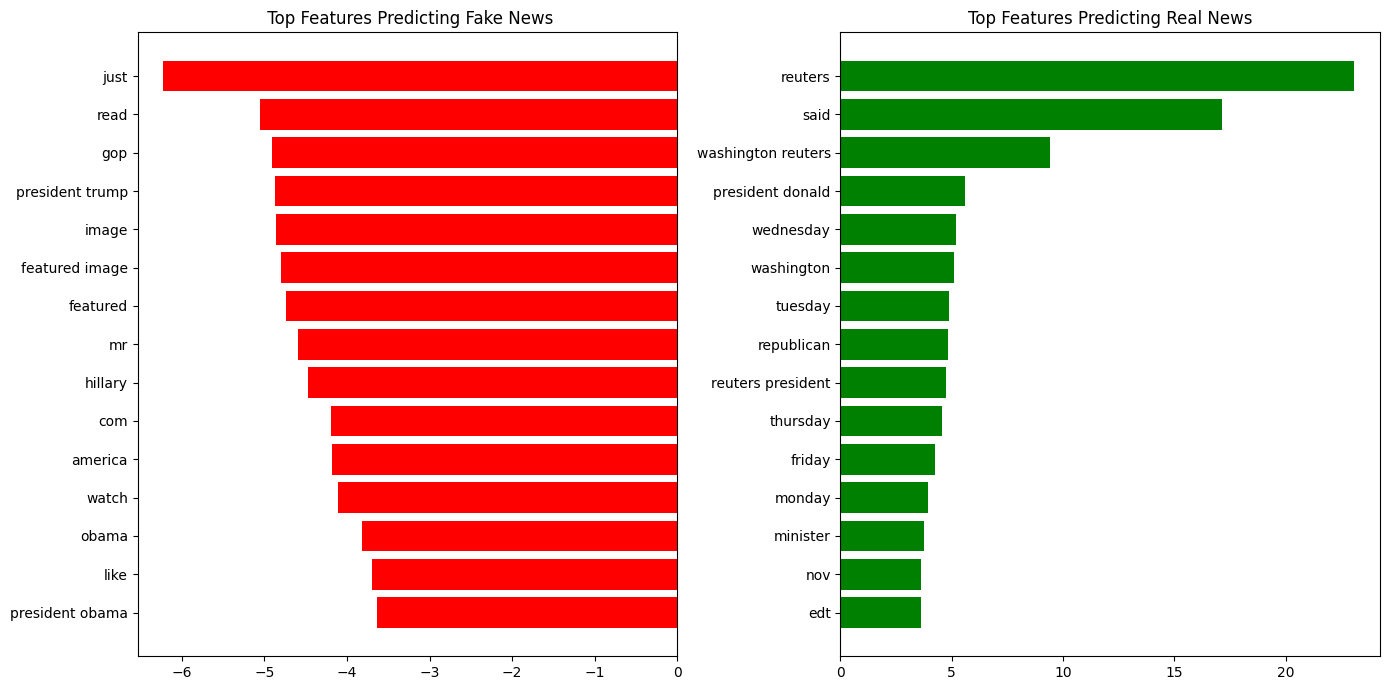

In [31]:
import matplotlib.pyplot as plt

def plot_top_features(model, top_n=15):
    vectorizer = model.named_steps["tfidf"]
    clf = model.named_steps["clf"]
    feature_names = vectorizer.get_feature_names_out()
    coefs = clf.coef_[0]

    # Get top features for each class
    top_fake_idx = np.argsort(coefs)[:top_n]
    top_real_idx = np.argsort(coefs)[-top_n:]

    top_fake = [(feature_names[i], coefs[i]) for i in top_fake_idx]
    top_real = [(feature_names[i], coefs[i]) for i in reversed(top_real_idx)]

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    # Fake News
    axes[0].barh([f[0] for f in top_fake], [f[1] for f in top_fake], color='red')
    axes[0].set_title(" Top Features Predicting Fake News")
    axes[0].invert_yaxis()
    
    # Real News
    axes[1].barh([f[0] for f in top_real], [f[1] for f in top_real], color='green')
    axes[1].set_title("Top Features Predicting Real News")
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
plot_top_features(model, top_n=15)




Looking at the most predictive features for fake news, we see a pattern of emotionally charged or politically polarizing terms — such as *"hillary"*, *"watch"*, *"gop"*, and phrases like *"featured image"*. These reflect the online content style that dominated during the **2016 U.S. election cycle**, which aligns with the timeline revealed in my earlier time-series analysis.

This period saw the rise of hyper-targeted disinformation campaigns, notably through platforms like Facebook, as highlighted in the [Cambridge Analytica case study](https://caseworks.business.columbia.edu/caseworks/cambridge-analytica-scandal-psychographics-facebook-and-2016-us-elections).

In contrast, the features most associated with **real news** are far more institutional — dominated by timestamped reporting language (*"monday"*, *"reuters"*, *"said"*, *"minister"*) — suggesting consistent editorial standards and sourcing practices.


### Now that a baseline is established, I focus on practical improvements under time constrainte. I focused on Advanced feature engineering: Adding the article title as an additional signal.

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Combine title and text
def add_title_text(df):
    df["combined"] = df["title"].fillna("") + " " + df["text"].fillna("")
    return df

# Build improved model
def build_improved_model():
    return Pipeline([
        ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words="english")),
        ("clf", LogisticRegression(max_iter=1000))
    ])

# Evaluate
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("📊 Classification Report:\n")
    print(classification_report(y_test, y_pred, digits=3))

# Run all steps
df = add_title_text(df)
X_train_new, X_test_new, y_train, y_test = train_test_split(df["combined"], df["label"], stratify=df["label"], test_size=0.2, random_state=42)
improved_model = build_improved_model()
improved_model.fit(X_train_new, y_train)
evaluate_model(improved_model, X_test_new, y_test)


📊 Classification Report:

              precision    recall  f1-score   support

           0      0.992     0.985     0.989      4696
           1      0.984     0.992     0.988      4284

    accuracy                          0.988      8980
   macro avg      0.988     0.989     0.988      8980
weighted avg      0.988     0.988     0.988      8980



Adding the article "title" to the text input led to a slight improvement in classification performance:

- Fake news F1 increased from 0.988 → 0.989
- Real news F1 increased from 0.987 → 0.988

While the overall accuracy remained the same, this confirms that even small feature engineering tweaks can help the model better capture subtle cues — especially those embedded in emotionally charged or clickbait-style headlines. Given the time constraints, this was a fast and interpretable win.